<p style="text-align:center;">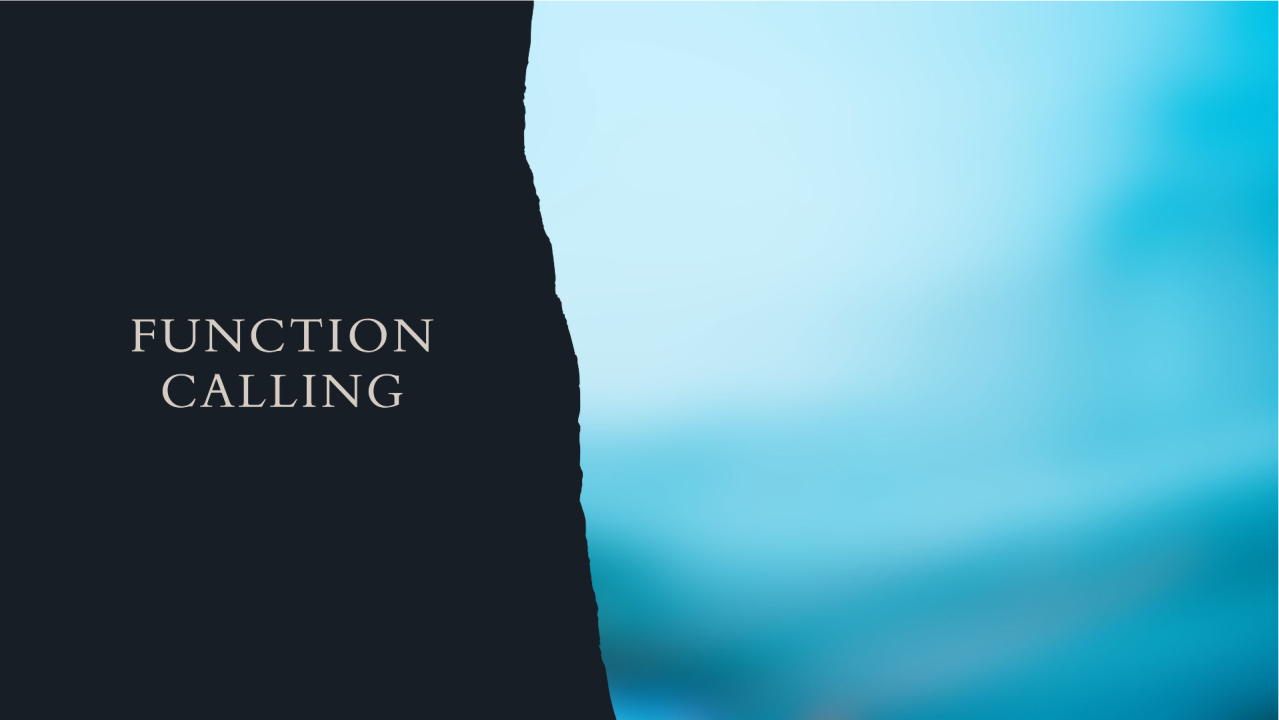
</p>

This post illustrates how to use function calling of Mixtral-8x22B-Instruct-v0.1 to retrieve data from database in order to answer user's questions.

In [1]:
import json
import os
import re
import requests
import sqlite3

from pathlib import Path

from transformers import AutoTokenizer
from llama_index.llms.openai_like import OpenAILike

from dotenv import load_dotenv
load_dotenv();

## Download sqlite3 sample database `chinook`

In [2]:
!wget https://www.sqlitetutorial.net/wp-content/uploads/2018/03/chinook.zip

--2024-05-29 18:03:16--  https://www.sqlitetutorial.net/wp-content/uploads/2018/03/chinook.zip
Resolving www.sqlitetutorial.net (www.sqlitetutorial.net)... 172.64.80.1, 2606:4700:130:436c:6f75:6466:6c61:7265
Connecting to www.sqlitetutorial.net (www.sqlitetutorial.net)|172.64.80.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 305596 (298K) [application/zip]
Saving to: ‘chinook.zip’

chinook.zip         100%[===================>] 298.43K  --.-KB/s    in 0.007s  

2024-05-29 18:03:16 (44.4 MB/s) - ‘chinook.zip’ saved [305596/305596]



In [3]:
!unzip chinook.zip

Archive:  chinook.zip
  inflating: chinook.db              


## Setup model and tokenizer
The model is hosted using tabbyAPI locally. We'll use "OpenAILike" from LlamaIndex to send requests to it.

In [4]:
def get_model_name():
    BASE_URL = os.environ['BASE_URL']
    headers = {
        'accept': 'application/json',
        'x-api-key': os.environ['API_KEY']
    }
    res = requests.get(os.path.join(BASE_URL, 'model'), headers=headers).json()
    if 'id' not in res:
        raise Exception('Model not loaded.')
    return res['id']

In [5]:
model_name = get_model_name()
print(model_name)

llm = OpenAILike(
    model=model_name,
    api_base=os.environ['BASE_URL'],
    api_key=os.environ['API_KEY']
)
tokenizer = AutoTokenizer.from_pretrained('mistralai/Mixtral-8x22B-Instruct-v0.1')

Mixtral-8x22B-Instruct-v0.1-exl2-4.0bpw


## Setup function tools

In [6]:
# 
# functions to be used as tools
# 
def search_customer_support(customer_firstname: str, customer_lastname) -> list[tuple[str, str, int]]|None:
    """search customers table and return support representative id."""
    stmt = (
        "SELECT SupportRepid FROM customers "
        f"WHERE FirstName LIKE '%{customer_firstname}%' and LastName LIKE '%{customer_lastname}%'"
    )
    res = conn.execute(stmt).fetchall()
    if len(res) == 0:
        res = None
    return res[0][0]

def search_employee(employee_id: int) -> list[tuple[str, str, str]]|None:
    """search employees table and return firstname, lastname and title."""
    stmt = (
        "SELECT FirstName, LastName, Title FROM employees "
        f"WHERE Employeeid={employee_id}"
    )
    res = conn.execute(stmt).fetchall()
    if len(res) == 0:
        res = None
    return res[0]

Create tools for the model.

In [7]:
name_fn_mappings = {
    'search_customer_support': search_customer_support,
    'search_employee': search_employee
}

tools = [
    {"type": "function",
     "function": {
         "name":"search_customer_support",
         "description": "Useful when you want to find out who provided support to a customer.",
         "parameters": {
             "type": "object",
             "properties": {
                 "customer_firstname": {
                     "type": "string",
                     "description": "A customer's first name."},
                 "customer_lastname": {
                     "type": "string",
                     "description": "A customer's last name."}
                 },
             "required":["customer_firstname", "customer_lastname"]
             }
         }
    },
    {"type": "function",
     "function": {
         "name":"search_employee",
         "description": "Useful when you want to retrieve more information about an employee.",
         "parameters": {
             "type": "object",
             "properties": {
                 "employee_id": {
                     "type": "integer",
                     "description": "employee's id"}
                 },
             "required":["employee_id"]
             }
         }
    }    
]

## Run query with function calling
Define some required functions in order to run queries first.

In [8]:
def format_prompt(messages, tokenizer, use_tool=False, tools=None):
    if use_tool:
        if tools is None or len(tools)==0:
            raise Exception('A list of tools is required for function calling.')
        prompt = tokenizer.apply_chat_template(
            messages,
            chat_template='tool_use',
            tools=json.dumps(tools),
            tokenize=False,
            add_generation_prompt=True)
    else:
        prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    return prompt

In [9]:
def call_tool(toolcall):
    fn = name_fn_mappings[toolcall['name']]
    fn_results = fn(**toolcall['arguments'])
    return fn_results

def get_first_toolcall(response):
    m = re.findall('(\[\{\s*"name":.*\}\])+', response)
    if len(m) > 0:
        toolcalls = json.loads(m[0])
        return toolcalls[0]
    else:
        return None

def run_step(messages):
    p = format_prompt(messages, tokenizer, True, tools)
    response = llm.complete(p, formatted=True).text.strip()
    return response, p

def ask_llm(messages):
    while True:
        response, p = run_step(messages)
        toolcall = get_first_toolcall(response)
        if toolcall:
            fn_results = call_tool(toolcall)
            messages.append(
                {'role': 'tool_calls', 'content': json.dumps([toolcall], ensure_ascii=False)}
            )
            messages.append(
                {'role': 'tool_results', 'content': json.dumps({"content": fn_results}, ensure_ascii=False)}
            )
        else:
            return response, p

### Ask the model questions

In [10]:
conn = sqlite3.connect('chinook.db')

In [11]:
messages=[
    {'role': 'user',
     'content': 'Get the firstname and lastname of the employee who provided customer support to Stanisław Wójcik.'}
]
response, prompt = ask_llm(messages)
print(prompt)
response

<s>[AVAILABLE_TOOLS][{"type": "function", "function": {"name": "search_customer_support", "description": "Useful when you want to find out who provided support to a customer.", "parameters": {"type": "object", "properties": {"customer_firstname": {"type": "string", "description": "A customer's first name."}, "customer_lastname": {"type": "string", "description": "A customer's last name."}}, "required": ["customer_firstname", "customer_lastname"]}}}, {"type": "function", "function": {"name": "search_employee", "description": "Useful when you want to retrieve more information about an employee.", "parameters": {"type": "object", "properties": {"employee_id": {"type": "integer", "description": "employee's id"}}, "required": ["employee_id"]}}}][/AVAILABLE_TOOLS][INST]Get the firstname and lastname of the employee who provided customer support to Stanisław Wójcik.[/INST][TOOL_CALLS][{"name": "search_customer_support", "arguments": {"customer_firstname": "Stanisław", "customer_lastname": "Wó

'The employee who provided customer support to Stanisław Wójcik is Margaret Park, a Sales Support Agent.'

In [12]:
conn.close()